# Introduction and setup

<p align="center">
    <img src="Flowcharts/Flare_filtering_flowchart.png" alt="plot" style="width:40%;">
</p>

In [12]:
import glob
import subprocess
import numpy as np
from astropy.io import fits
# from astropy.convolution import Gaussian2DKernel, convolve_fft
import matplotlib.pyplot as plt
# from astropy.visualization import make_lupton_rgb
# from astropy.wcs import WCS
import os
from tqdm import tqdm

In [3]:
# prepare a list of event files for evtool to read
elist = glob.glob('Data/Raw_data/???/???/EXP_010/e?01_??????_020_EventList_c010.fits.gz')
with open('Data/crab.list','w') as f:
    for e in elist:
        f.write(f'{e}\n')

In [4]:
if not os.path.exists('Data/Filtered_data'):
    os.system('mkdir Data/Filtered_data')

timebin='20'

clean_list, lightcurve_list = np.array(elist), np.array(elist)
for i in range(len(elist)):
    clean_list[i] = 'Data/Filtered_data/'+elist[i].split('/')[-1].replace('EventList_c010.fits.gz','c010_s01_CleanImage.fits')
    lightcurve_list[i] = 'Data/Filtered_data/'+elist[i].split('/')[-1].replace('EventList_c010.fits.gz',f'c010_s02_LightCurve_tb{timebin}.fits')

In [5]:
def run_evtool(input_name, output_name, gti_type='GTI', flag_type='0xe00fff30', pattern='15', emin='0.2', emax='10.0', image='yes', log_file=None):
    subprocess.run(['evtool', 
                    f'eventfiles={input_name}', 
                    f'outfile={output_name}', 
                    f'gti={gti_type}', 
                    f'flag={flag_type}', 
                    f'pattern={pattern}', 
                    f'emin={emin}', 
                    f'emax={emax}', 
                    f'image={image}',
                    ],
                    stdout=log_file,
                    stderr=log_file)
    
def run_radec2xy(input_name, ra, dec, log_file=None):
    subprocess.run(['radec2xy', 
                    f'{input_name}', 
                    f'ra0={ra}', 
                    f'dec0={dec}'],
                    stdout=log_file,
                    stderr=log_file)

In [6]:
with open('Data/Filtered_data/evtool.log', 'w+') as log_file:    
    for tile in tqdm(range(len(elist))):   
        run_evtool(elist[tile], clean_list[tile], log_file=log_file)
        # center_ra = fits.getval(clean_list[tile], "RA_CEN", ext=1)
        # center_dec = fits.getval(clean_list[tile], "DEC_CEN", ext=1)
        # run_radec2xy(clean_list[tile], center_ra, center_dec, log_file=log_file)

    log_file.seek(0)
    log_content = log_file.readlines()
    evtool_count = sum(1 for line in log_content if 'evtool: DONE' in line)
    # radec2xy_count = sum(1 for line in log_content if 'radec2xy: DONE' in line)
    print(f'evtool finished successfully for {evtool_count} out of {len(elist)} files ({evtool_count/len(elist)*100}%)')
    # print(f'radec2xy finished successfully for {radec2xy_count} out of {len(elist)} files ({radec2xy_count/len(elist)*100}%)')
    

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]

evtool finished successfully for 4 out of 4 files (100.0%)


In [7]:
def run_flaregti(input_name, output_lightcurve, pimin='5000', source_size='150', gridsize='26', timebin=timebin, log_file=None):
    subprocess.run(['flaregti', 
                    f'{input_name}', 
                    f'pimin={pimin}', 
                    f'source_size={source_size}',
                    f'gridsize={gridsize}',
                    f'lightcurve={output_lightcurve}',
                    'write_mask=no',
                    f'timebin={timebin}'],
                    stdout=log_file,
                    stderr=log_file)

In [8]:
with open('Data/Filtered_data/flaregti.log', 'w+') as log_file:
    for tile in tqdm(range(len(elist))):   
        run_flaregti(clean_list[tile], lightcurve_list[tile], log_file=log_file)
    
    log_file.seek(0)
    log_content = log_file.readlines()
    flaregti_count = sum(1 for line in log_content if 'flaregti: DONE' in line)
    print(f'flaregti finished successfully for {flaregti_count} out of {len(elist)} files ({flaregti_count/len(elist)*100}%)')

100%|██████████| 4/4 [00:02<00:00,  1.74it/s]

flaregti finished successfully for 4 out of 4 files (100.0%)


In [9]:
lightcurve = fits.open(lightcurve_list[1])
lightcrv = lightcurve[1].data
t = lightcrv.field('TIME')  # Given in numpy array
rate = lightcrv.field('RATE')
mean_rate = np.mean(rate)
std_rate = np.std(rate)
threshold = lightcrv.field('THRESHOLD')
rate_non0_idx = np.argwhere(rate != 0).flatten()
rate_non0 = rate[rate_non0_idx]
mean_rate_non0 = np.mean(rate_non0)
std_rate_non0 = np.std(rate_non0)

In [10]:
from astropy.modeling import models, fitting
from matplotlib.ticker import MultipleLocator

In [11]:
nsigma = 3

1.23


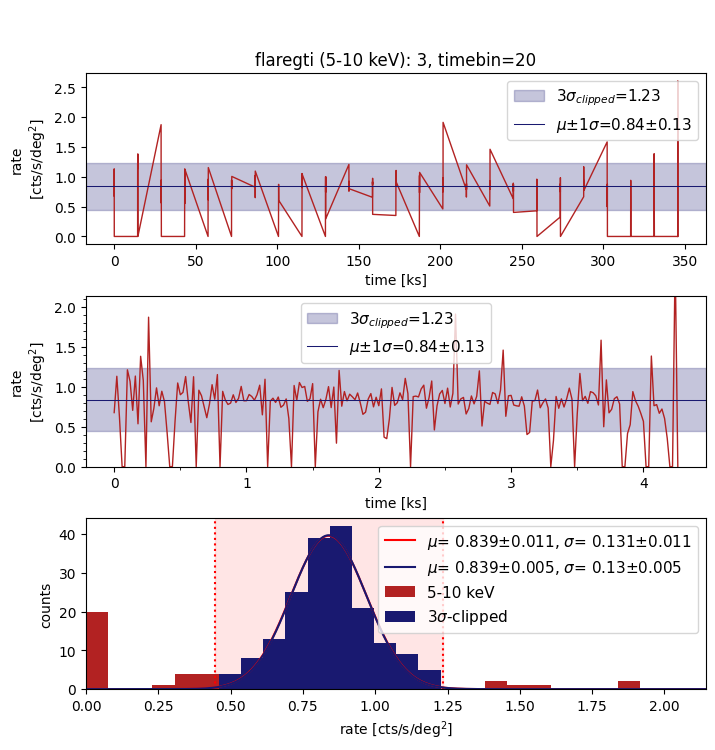

In [14]:
# Gaussian fit for the whole observation (http://learn.astropy.org/rst-tutorials/Models-Quick-Fit.html)
bin_heights, bin_borders = np.histogram(rate, bins='auto')
bin_widths = np.diff(bin_borders)
bin_centers = bin_borders[:-1] + bin_widths / 2
model_gauss = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit = fitter_gauss(model_gauss, bin_centers, bin_heights)
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
cov_diag = np.diag(fitter_gauss.fit_info['param_cov'])      # best fit error
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    yerr[np.argwhere(y<1)] = 1
    # fit (array) values for the fit
    # x,y,yerr (arrays) data
    # N total number of points
    # n_free number of parameters we are fitting
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)
reduced_chi_squared = calc_reduced_chi_square(best_fit(bin_centers), bin_centers, bin_heights, np.sqrt(bin_heights), len(bin_centers), 3)
stddev_clipmax = best_fit.mean.value + (nsigma * best_fit.stddev.value)
stddev_clipmin = best_fit.mean.value - (nsigma * best_fit.stddev.value)

# Gaussian fit non0
bin_heights_non0, bin_borders_non0 = np.histogram(rate_non0, bins=bin_borders)
bin_widths_non0 = np.diff(bin_borders_non0)
bin_centers_non0 = bin_borders_non0[:-1] + bin_widths_non0 / 2
model_gauss_non0 = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_non0 = fitter_gauss(model_gauss_non0, bin_centers_non0, bin_heights_non0)
x_interval_for_fit_non0 = np.linspace(bin_borders_non0[0], bin_borders_non0[-1], 10000)
cov_diag_non0 = np.diag(fitter_gauss.fit_info['param_cov'])      #best fit error
reduced_chi_squared_non0 = calc_reduced_chi_square(best_fit_non0(bin_centers_non0), bin_centers_non0, bin_heights_non0,
                                                 np.sqrt(bin_heights_non0), len(bin_centers_non0), 3)
stddev_clipmax_non0 = best_fit_non0.mean.value + (nsigma * best_fit_non0.stddev.value)
stddev_clipmin_non0 = best_fit_non0.mean.value - (nsigma * best_fit_non0.stddev.value)

# 3 sigma clipping
rate_sig_idx = np.argwhere((stddev_clipmin_non0 <= rate_non0) & (rate_non0 <= stddev_clipmax_non0)).flatten()
rate_sig = rate_non0[rate_sig_idx]
bin_heights_sig, bin_borders_sig = np.histogram(rate_sig, bins=bin_borders)
bin_widths_sig = np.diff(bin_borders_sig)
bin_centers_sig = bin_borders_sig[:-1] + bin_widths_sig / 2
model_gauss_sig = models.Gaussian1D()
fitter_gauss = fitting.LevMarLSQFitter()
best_fit_sig = fitter_gauss(model_gauss_sig, bin_centers_sig, bin_heights_sig)
x_interval_for_fit_sig = np.linspace(bin_borders_sig[0], bin_borders_sig[-1], 10000)
cov_diag_sig = np.diag(fitter_gauss.fit_info['param_cov'])      #best fit error
reduced_chi_squared_sig = calc_reduced_chi_square(best_fit_sig(bin_centers_sig), bin_centers_sig, bin_heights_sig,
                                                 np.sqrt(bin_heights_sig), len(bin_centers_sig), 3)
stddev_clipmax_sig = best_fit_sig.mean.value + (nsigma * best_fit_sig.stddev.value)
stddev_clipmin_sig = best_fit_sig.mean.value - (nsigma * best_fit_sig.stddev.value)
print(round(stddev_clipmax_sig, 2))  # for SH_filtering input threshold

# PLOTTING
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot((t - t[0])/1e3, rate, linewidth=1.0, color='firebrick')
#plt.plot(np.arange(0, len(rate_non0_idx), 1)/1e3, rate_non0, linewidth=1.0, color='firebrick')
plt.axhspan(stddev_clipmin_sig, stddev_clipmax_sig, color='midnightblue', alpha=0.25,
            label='${1}\sigma_{{clipped}}$={0}'.format(round((stddev_clipmax_sig), 2), nsigma))
plt.axhline(best_fit_sig.mean.value, color='midnightblue', linewidth=0.75, label='$\mu±1\sigma$={0}±{1}'
            .format(round(best_fit_sig.mean.value, 2), round(best_fit_sig.stddev.value, 2)))
plt.xlabel('time [ks]')
plt.ylabel('rate\n[cts/s/deg$^2$]')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(1e3))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
plt.legend(loc='best', fontsize=11)
plt.title('\n\nflaregti (5-10 keV): {0}, timebin={1}'.format(tile, timebin))
timebin=20
plt.subplot(312)
#plt.plot(np.arange(0, len(rate_non0_idx), 1)*timebin/1e3, rate_non0, linewidth=1.0, color='firebrick')
plt.plot(np.arange(0, len(rate), 1)*timebin/1e3, rate, linewidth=1.0, color='firebrick')
plt.axhspan(stddev_clipmin_sig, stddev_clipmax_sig, color='midnightblue', alpha=0.25,
            label='${1}\sigma_{{clipped}}$={0}'.format(round((stddev_clipmax_sig), 2), nsigma))
plt.axhline(best_fit_sig.mean.value, color='midnightblue', linewidth=0.75, label='$\mu±1\sigma$={0}±{1}'
            .format(round(best_fit_sig.mean.value, 2), round(best_fit_sig.stddev.value, 2)))
plt.xlabel('time [ks]')
plt.ylabel('rate\n[cts/s/deg$^2$]')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
plt.ylim(0, best_fit_sig.mean.value + 10*best_fit_sig.stddev.value)
plt.legend(loc='best', fontsize=11)

plt.subplot(313)
plt.bar(bin_centers, bin_heights, width=bin_widths, color='firebrick', label='5-10 keV')
plt.plot(x_interval_for_fit, best_fit(x_interval_for_fit), c='red',
         label='$\mu$= {0}$\pm${1}, $\sigma$= {2}$\pm${3}'  #  \n $\chi_r^2$= {4}
         .format(round(best_fit.mean.value, 3), round(np.sqrt(cov_diag[1]), 3), round(best_fit.stddev.value, 3),
                 round(np.sqrt(cov_diag[2]), 3)))  # , round(reduced_chi_squared, 2)
plt.axvspan(stddev_clipmax, stddev_clipmin, color='red', alpha=0.1)
plt.axvline(stddev_clipmax, linestyle='dotted', color='red')
plt.axvline(stddev_clipmin, linestyle='dotted', color='red')
plt.bar(bin_centers_sig, bin_heights_sig, width=bin_widths_sig, color='midnightblue', label='${0}\sigma$-clipped'.format(nsigma))
plt.plot(x_interval_for_fit_sig, best_fit_sig(x_interval_for_fit_sig), c='midnightblue',
         label='$\mu$= {0}$\pm${1}, $\sigma$= {2}$\pm${3}'
         .format(round(best_fit_sig.mean.value, 3), round(np.sqrt(cov_diag_sig[1]), 3),
                 round(best_fit_sig.stddev.value, 3), round(np.sqrt(cov_diag_sig[2]), 3)))
#plt.grid(True, linestyle='dotted')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.xlim(0, best_fit_sig.mean.value + 10*best_fit_sig.stddev.value)
plt.xlabel('rate [cts/s/deg$^2$]')
plt.ylabel('counts')
plt.legend(loc='best', fontsize=11)
plt.legend(loc='best', fontsize=11)
# plt.savefig('{0}/PLT_LC_{1}_lightcurve1_{2}s.pdf'.format(path, tile, timebin))
